**Note: This notebook is designed to run on Google Colab. To get it to run, please upload this to your own GDrive, and run it from there.**

First, mount your Google Drive to the Colab instance.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Download required data files from GitHub repository.

In [ ]:
from os import path
if not path.exists("/content/drive/MyDrive/Data-Science-for-Buildings-and-Energy/datasets/heatingload_case5.csv"):
  !mkdir /content/drive/MyDrive/Data-Science-for-Buildings-and-Energy/
  !git clone https://github.com/henze-research-group/Data-Science-for-Buildings-and-Energy.git /content/drive/MyDrive/Data-Science-for-Buildings-and-Energy/

# **Data Science for Energy and Buildings**

Authors: Gregor Henze and Thibault Marzullo, Tim Diller

Revised: October 30, 2023

## **Introduction**

This notebook explores the application of several data science (machine learning) approaches to the problem of predicting 24-hour heating load profiles of a hydronic radiant heating system in a five-zone home, shown in Figure 1, given 30 days of past measurements of external air temperature (Text) and global horizontal irradiation (GHI). The objective is to provide a high-level introduction to the application of these approaches.
The home has been modeled using a detailed building energy modeling program (TRNSYS), and represents a residential apartment located in Bolzano (Italy), with a good insulation level and 62.6 m² of heated area.

The tree-based approaches presented here are:

1. Single regression tree and tree pruning
2. Tree bootstrap aggregation (bagging and random patches)
3. Random forest
4. Boosting




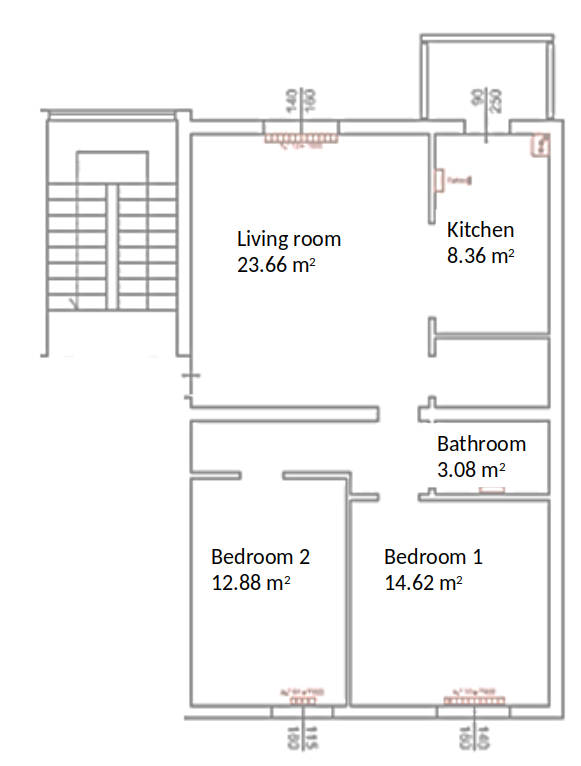

Figure 1: The floor plan of the house modeled in the building energy modeling program TRNSYS used in this analysis


## **Setup**

We load required libraries including matplotlib, pandas, numpy, math, and scikit-learn.

In [ ]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import math
from datetime import datetime

from sklearn import tree
from sklearn.model_selection import train_test_split, KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.inspection import permutation_importance
#from sklearn.exceptions import UserWarning
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

Here, we define a few useful functions.

In [ ]:
def cvrmse(y_hat : np.ndarray, y : np.ndarray, **kwargs):
    """
    Coefficient of Variation based on the Root Mean Squared Error.

    Parameters
    ----------
    y_hat : np.ndarray of shape (nSamples,) or (nSamples, nSignals)
        The estimated signals.
    y : np.ndarray of shape (nSamples,) or (nSamples, nSignals)
        The reference signals.
    **kwargs : keyword arguments
        Other arguments to be passed to mean_squared_error.

    Returns
    -------
    Coefficient of variation of the signals as a percentage.
    """

    e = y_hat - y
    rmse = np.sqrt(np.sum(e*e, axis = 0)/e.shape[0])
    return rmse*100./y.mean()

def nmbe(y_hat : np.ndarray, y : np.ndarray, **kwargs):
    """
    Normalized Mean Bias Error.

    Parameters
    ----------
    y_hat : np.ndarray of shape (nSamples,) or (nSamples, nSignals)
        The estimated signals.
    y : np.ndarray of shape (nSamples,) or (nSamples, nSignals)
        The reference signals.
    **kwargs : keyword arguments
        Other arguments to be passed to mean_squared_error.

    Returns
    -------
    Normalized mean bias error of the signals as a percentage.
    """
    e = y_hat - y
    return np.sum(e, axis=0)*100./y.mean()

def gof(y_hat : np.ndarray, y : np.ndarray, w_cvrmse = 1, w_nmbe = 3, **kwargs):
    """
    Goodness of Fit.

    Parameters
    ----------
    y_hat : np.ndarray of shape (nSamples,) or (nSamples, nSignals)
        The estimated signals.
    y : np.ndarray of shape (nSamples,) or (nSamples, nSignals)
        The reference signals.
    w_cvrmse : float or int
        Weighting factor for CV(RMSE).
    w_nmbe : float or int
        Weighting factor for NMBE.
    **kwargs : keyword arguments
        Other arguments to be passed.

    Returns
    -------
    Goodness of fit of the estimate relative to the reference signal.
    """
    # default weights are set according to ASHRAE Guideline 14
    return np.sqrt(((w_cvrmse * cvrmse(y_hat, y))**2 + (w_nmbe * nmbe(y_hat, y))**2)/(w_cvrmse**2 + w_nmbe**2))

def singlePredPlot(y_test_m, predictions, labels, testxlabels, step, length = 10):
    '''
    Helper function that plots one or multiple predictions for a visual
    performance comparison between several prediction methods.

    Parameters
    ----------
    y_test_m : np.ndarray of shape (nSamples,)
        Ground truth.
    predictions : np.ndarray of shape (nSamples,) or list of np.ndarrays
        Predictions.
    labels : list of strings
        Names used for plotting the predictions.
    testxlabels : list of datetimes
        Dates used for the x axis labels.
    step : int
        Timestep used in the dataset, used to place labels on the x axis.

    Returns
    -------
    Nothing.
    '''


    fig = go.Figure()
    xaxis = np.arange(0, len(y_test_m), 1)
    # predictions = [prediction_lreg]
    # labels = ["linear regression"]

    # Plot ground truth
    fig.add_trace(go.Scatter(x=xaxis, y=y_test_m, mode='lines', name='Ground Truth', line=dict(dash='dash')))

    # Plot predictions and update title
    # title = f'{labels[0]} (CVRMSE: {round(cvrmse(predictions[0][0], y_test_m[0]), 1)}%)' + ' ' + \
    #        ' '.join([f'vs. {labels[i]} (CVRMSE: {round(cvrmse(predictions[i][0], y_test_m[0]), 1)}%)' for i in range(1, len(labels))])

    # if we only have labels once, we plot the single line
    if isinstance(labels, str):
        fig.add_trace(go.Scatter(x=xaxis, y=predictions, mode='lines', name=labels, line=dict(width=3)))
    else: # if we have more than one, we plot them all.
        for i in range(len(labels)):
            fig.add_trace(go.Scatter(x=xaxis, y=predictions[i], mode='lines', name=labels[i], line=dict(width=3) if i == 0 else {}))

    # Customize layout
    fig.update_layout(
        xaxis=dict(title="Date", tickmode='array', tickvals=[i * 24 * 3600 / step for i in range(len(y_test_m))], ticktext=testxlabels),
        yaxis=dict(title="Power demand (W)"),
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
    )

    # Show the plot
    fig.show()


    return None


def multiPredPlot(y_test_m, results, label, testxlabels, step):
    '''
    Helper function that plots a series of predictions against ground truth.

    Parameters
    ----------
    y_test_m : np.ndarray of shape (nSamples,)
        Ground truth.
    results : list of np.ndarrays
        Prediction.
    label : string
        Name used for plotting the prediction.
    testxlabels : list of datetimes
        Dates used for the x axis labels.
    step : int
        Timestep used in the dataset, used to place labels on the x axis.

    Returns
    -------
    Nothing.
    '''
    xresults = [[i+j*24*3600/step for i in range(len(results[0]))] for j in range(len(results))]
    xtesting = [i for i in range(len(y_test_m))]
    global_results = [item for sublist in results for item in sublist]

    fig = go.Figure()

    # Plot individual results
    for i in range(len(results)):
        fig.add_trace(go.Scatter(x=xresults[i], y=results[i], mode='markers', marker=dict(symbol='x'), name=f'Result {i+1}'))

    # Plot ground truth
    fig.add_trace(go.Scatter(x=xtesting, y=y_test_m, mode='lines', name='Ground Truth'))

    # Customize layout
    fig.update_layout(
        title="%s, CV(RMSE) = %.1f%%" % (label, cvrmse(global_results, y_test_m)),
        xaxis=dict(title="Date", tickmode='array', tickvals=[i * 24 * 3600 / step for i in range(10)], ticktext=testxlabels),
        yaxis=dict(title="Power demand (W)"),
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
    )

    # Show the plot
    fig.show()
    return None

def predictWithRetraining(method, name, args):
  #inp=inp, out=out, X_test_m=X_test_m, y_test_m=y_test_m, Start=Start, Training=Training, Interval=Interval, Horizon=Horizon, testxlabels=testxlabels, step=step):
  '''
  Make a prediction using the prediction algorithm "method", for "Horizon" days, re-training
  the prediction algorithm at "Interval" days of interval.

  Parameters
  ----------
  method : sklearn predictor object
    Predictor used in this function. Can be any Sklearn object that has a .fit() and a .predict() method.
  name : string
    Name of the predictor, for plotting
  Horizon : int
    Forecast horizon, in days.
  '''
  results = []
  day = int(24 * 3600 / args['step'])
  trainlen = day * args['Training']
  testlen = day * args['Interval']
  start_day = abs((datetime.strptime(args['Start'], "%Y-%m-%d") - args['inp'].index[0]).days) * day


  for k in range(Horizon):
    # One-step ahead forecast, repeated for the length of the test vector
    x_train_moving = args['inp'].iloc[start_day + k * testlen : start_day +
                              trainlen + k * testlen]
    y_train_moving = args['out'].iloc[start_day + k * testlen : start_day +
                              trainlen + k * testlen]
    method.fit(x_train_moving, y_train_moving)
    x_test = args['X_test_m'].iloc[k * testlen : k * testlen + testlen].copy()
    results.append(method.predict(x_test.to_numpy()))

  multiPredPlot(args['y_test_m'], results, name, args['testxlabels'], args['step'])
  return results

## **Pre-processing, part 1: formatting the data**

All datasets are provided with a 5-minute resolution. Three datasets are available, representing the same system with varying levels of modeling complexity.

1.   Case 5 (Test 20): Ideal heating loads without internal gains
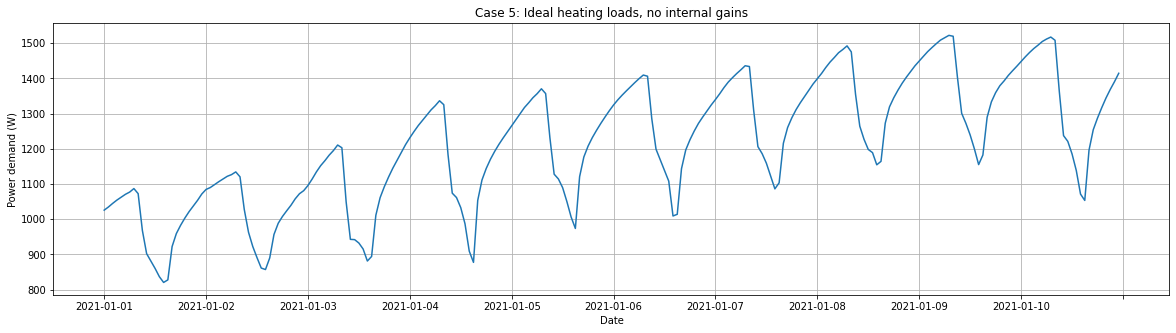
2.   Case 6 (Test 23): Ideal heating loads with internal gains
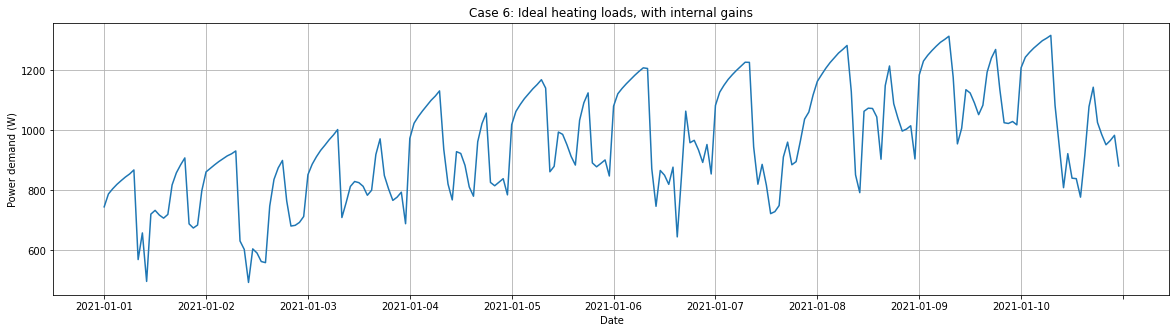
3.   Case 7 (Test 32): Realistic heating loads with internal gains
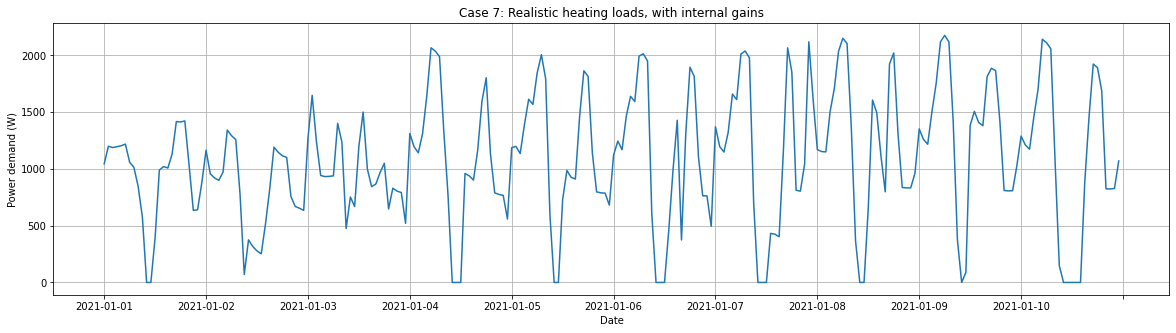

The dataset will be filtered to average data at varying intervals (1-hour, 30-minutes, 15-minutes and 5-minutes) for two predictors only: external air temperature (Text) and global horizontal irradiance (GHI).

Additionally, this code generates new predictors for extracting:
* Hourly values for **past** 24 hours of GHI
* Hourly values for **past** 24 hours of Text

You can inspect the code below by clicking the arrow on the top left corner of this text box, and collapse it again for readability.



**Loading the data:**

In [ ]:
#@title Select a test case { run: "auto" }
Testcase = 'Case 5 - Ideal loads, no internal gains' #@param ["Case 5 - Ideal loads, no internal gains", "Case 6 - Ideal loads, with internal gains", "Case 7 - Realistic loads, with internal gains"]
case = Testcase

#@markdown Select how many hours into the past the input variables will be lagged
hours_into_the_past= 24 #@param {type:"integer"}
#@markdown Check the box below if you want the variables to be lagged at hourly intervals, and uncheck it if you want lags at the maximum sampling frequency (ex: if the box is unchecked, a 15-minute frequency will result in 4 lagged variables per hour into the past. If it is checked, the lags will be at hourly intervals regardless of the sampling frequency.)
hourly_lag = True #@param {type:"boolean"}

In [ ]:
def caseSelect(case = Testcase):

  '''
  Extract a Pandas DataFrame from a CSV file present in the GitHub repository.

  Parameters
  ----------
  case : string
    Case name.

  Returns
  -------
  data : DataFrame
    The raw dataset, extracted from the corresponding csv file.
  '''
  if case == "Case 5 - Ideal loads, no internal gains":
    filename = "/content/drive/MyDrive/Data-Science-for-Buildings-and-Energy/datasets/heatingload_case5.csv"
  elif case == "Case 6 - Ideal loads, with internal gains":
    filename = "/content/drive/MyDrive/Data-Science-for-Buildings-and-Energy/datasets/heatingload_case6.csv"
  elif case == "Case 7 - Realistic loads, with internal gains":
    filename = "/content/drive/MyDrive/Data-Science-for-Buildings-and-Energy/datasets/heatingload_case7.csv"
  else:
    "Error: case does not exist."

  data = pd.read_csv(filename, delimiter=',', header = [0, 1])
  data = pd.DataFrame(data)
  data.columns = data.columns.droplevel(level = 1) # The header is split across 2 rows. We drop the second row manually.

  print("Original dataset")
  print(data)

  return data

In [ ]:
data_presampling = caseSelect()

Original dataset
             TIME   T_EXT  HR_EXT   X_EXT  T_LR  T_BR1  T_BR2    HR_LR  \
0        744.0000  4.8458  51.750  0.0028  21.0   21.0   21.0  87.5442   
1        744.0833  4.7583  52.125  0.0028  21.0   21.0   21.0  87.4583   
2        744.1667  4.6750  52.375  0.0028  21.0   21.0   21.0  87.3558   
3        744.2500  4.5917  52.625  0.0028  21.0   21.0   21.0  87.2549   
4        744.3333  4.5083  52.875  0.0028  21.0   21.0   21.0  87.1559   
...           ...     ...     ...     ...   ...    ...    ...      ...   
105116  9503.6667  5.2125  49.750  0.0028  21.0   21.0   21.0  87.8317   
105117  9503.7500  5.1208  50.250  0.0028  21.0   21.0   21.0  87.7589   
105118  9503.8333  5.0292  50.750  0.0028  21.0   21.0   21.0  87.6876   
105119  9503.9167  4.9375  51.250  0.0028  21.0   21.0   21.0  87.6174   
105120  9504.0000  4.8458  51.750  0.0028  21.0   21.0   21.0  87.5484   

         HR_BR1   HR_BR2  ...  B4_QHEAT_A_Kitchen  B4_QHEAT_A_Bathroom  \
0       82.4708  83.

**Resampling data set:**

Resample the dataset from a 5-minute frequency (5T) to a new frequency defined in by `sampling` by computing the mean value of intermediate samples.
See [the usage of the .resample() method](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html)
and
[the explanation for the 5T and H string objects used to set the frequency.](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects)

NOTE: Do not run this several times in a row, or the data frame will be resampled multiple times. Run block 50 again should this happen.

In [ ]:
#@title Select the sampling frequency { run: "auto" }
Sampling = '1-hour' #@param ["1-hour", "30-minutes", "15-minutes", "5-minutes"]
sampling = Sampling

In [ ]:
def resampleData(sampling = sampling, data = data_presampling):

  '''
  Resample a Pandas DataFrame.

  Parameters
  ----------
  sampling : string
    Sampling frequency for the new DataFrame.
  data : DataFrame
    Dataset to resample.

  Returns
  -------
  new : DataFrame
    The resampled dataset.
  step : int
    The timestep (in seconds) after resampling.
  '''
  data['DateTimeIndex'] = pd.date_range('2/1/2020', periods=len(data[data.columns[0]]), freq='5T') # Create datetime index
  data.set_index('DateTimeIndex', inplace=True) # Replace the current dataframe index with the one just created. It makes it slightly easier to use the resample() method.

  if sampling == "15-minutes":
    print("Using sampling of %s" % sampling)
    data = data.resample('15T').mean() # Resample the data at 15-minutes frequency using the mean value
    step = 900
  elif sampling == "30-minutes":
    print("Using sampling of %s" % sampling)
    data = data.resample('30T').mean() # Resample the data at a 30-minutes frequency using the mean value
    step = 1800
  elif sampling == "1-hour":
    step = 3600
    print("Using sampling of %s" % sampling)
    data = data.resample('H').mean() # Resample the data at a hourly frequency using the mean value
  else:
    print("Using sampling of %s" % sampling)
    step = 300
  # Note how the "TIME" column is averaged to the mean value of the decimal hour. This means that the value at time t is computed using the mean of the values between t and t + 1 hour.
  new = pd.DataFrame()
  new['Qdot_0'] = data['Total heating load ']
  new['Text_0'] = data['T_EXT']
  new['GHI_0'] = data['IRR_HOR']
#  new['hour_year'] = data['TIME']
  return new, step

In [ ]:
data, step = resampleData()
print(data.head(24))

Using sampling of 1-hour
                          Qdot_0    Text_0        GHI_0
DateTimeIndex                                          
2020-02-01 00:00:00   924.466667  4.383675     0.000000
2020-02-01 01:00:00   944.608333  3.341325     0.000000
2020-02-01 02:00:00   965.816667  2.283675     0.000000
2020-02-01 03:00:00   985.175000  1.409375     0.000000
2020-02-01 04:00:00  1001.991667  0.750350     0.000000
2020-02-01 05:00:00  1017.750000  0.192017     0.000000
2020-02-01 06:00:00  1031.425000 -0.266325     0.000000
2020-02-01 07:00:00  1045.533333 -0.540625     2.025000
2020-02-01 08:00:00   903.850000 -0.053467   292.866892
2020-02-01 09:00:00   772.491667  1.451733   752.447900
2020-02-01 10:00:00   752.641667  3.250000  1176.643133
2020-02-01 11:00:00   784.450000  4.923958  1437.577917
2020-02-01 12:00:00   790.766667  6.298958  1602.048025
2020-02-01 13:00:00   764.791667  7.289933  1516.869558
2020-02-01 14:00:00   693.875000  7.781592  1222.473150
2020-02-01 15:00:00   6

Add a window of past values as additional predictors based on the selected horizon of past predictors.

In [ ]:
def generateLagged(hours_into_the_past = hours_into_the_past, hourly_lag = hourly_lag, step = step, data = data):

  '''
  Generate lagged predictors.
  Note: currently, the predictors are hardcoded. They are Text and GHI.

  Parameters
  ----------
  hours_into_the_past : int
    Lag horizon. The lagged variables will span from time t = t0 - hours_into_the_past to time t = t0.
  hourly_lag : Bool
    If True, generate lags that are strictly hourly (ex: t - 1 hour, t - 2 hours, etc.).
    Else, generate lags that depend on the sampling frequency (ex: 15-minutes frequency
    will generate 4 lags per hour).
  step : int
    Step size, in seconds, in this dataset.
  data : DataFrame
    Original dataset

  Returns
  -------
  data : DataFrame
    The new dataset, which now includes lagged predictors.
  '''
  # in case of repeated use of this function, keep only base columns
  if len(data.columns) > 3:
    data = data.copy()[['Qdot_0', 'Text_0', 'GHI_0']]

  lags = int(hours_into_the_past * 3600 / step + 1)


  for i in range(1, lags):
    if hourly_lag:
      if i % (3600 / step) == 0:
        data['Text_-'+str(int(i / (3600 / step)))] = data['Text_0'].shift(periods=i)
        data['GHI_-'+str(int(i / (3600 / step)))] = data['GHI_0'].shift(periods=i)
    else:
      data['Text_-'+str(i)] = data['Text_0'].shift(periods=i)
      data['GHI_-'+str(i)] = data['GHI_0'].shift(periods=i)
  data = data.iloc[lags - 1:] # Shifting columns generates 24 rows with missing values. This line drops these rows with missing data.
  print("For 24 hours, we introduce %d lags" % int((len(data.columns) - 3)/2))
  return data

In [ ]:
data = generateLagged()

For 24 hours, we introduce 24 lags


Inspect the new dataset:

In [ ]:
print("New dataset")
print(data)
print(data.columns)

New dataset
                          Qdot_0    Text_0  GHI_0   Text_-1  GHI_-1   Text_-2  \
DateTimeIndex                                                                   
2020-02-02 00:00:00   989.575000 -0.207292    0.0  0.467017     0.0  1.324650   
2020-02-02 01:00:00  1009.200000 -0.666325    0.0 -0.207292     0.0  0.467017   
2020-02-02 02:00:00  1028.650000 -1.108675    0.0 -0.666325     0.0 -0.207292   
2020-02-02 03:00:00  1046.916667 -1.482292    0.0 -1.108675     0.0 -0.666325   
2020-02-02 04:00:00  1063.091667 -1.725350    0.0 -1.482292     0.0 -1.108675   
...                          ...       ...    ...       ...     ...       ...   
2021-01-30 20:00:00   846.791667  8.267017    0.0  9.124650     0.0  9.970492   
2021-01-30 21:00:00   866.383333  7.424650    0.0  8.267017     0.0  9.124650   
2021-01-30 22:00:00   885.283333  6.482983    0.0  7.424650     0.0  8.267017   
2021-01-30 23:00:00   904.766667  5.441325    0.0  6.482983     0.0  7.424650   
2021-01-31 00:00

## **Pre-processing, part 2: Preparing training and testing data**

This section splits the dataset into two portions: One for training the regression model, another for testing the model's prediction capabilities on unseen data.

Two methods are shown in the code:
1. Using random samples extracted using sklearn's train_test_split method
2. Manually selecting a 30-day training and a 1-day testing dataset *

** This method is used in this notebook for demonstrating an implementation of an "online" learning approach.*

You can inspect the code below by clicking the arrow on the top left corner of this text box and collapse it again for readability.


**Extracting the testing and training datasets**

In [ ]:
#@title Sampling of training and testing data { run: "auto" }
randomsamples = False #@param {type:"boolean"}
#@markdown Check this box if you want to sample the data randomly throughout the dataset. Uncheck it to manually define the training and testing horizons.

#@markdown ---
#@markdown **If `randomsamples` is deselected, please input testing and training horizons below.**

#@markdown Select the number of days of training
Training = 30 #@param {type:"integer"}
#@markdown Select the interval, in days, between two trainings. Ex.: setting this value to 1 will re-train the model every day on the past `Training` days of data.
Interval = 1 #@param {type:"integer"}
#@markdown Select the forecasting horizon, in days
Horizon = 10 #@param {type:"integer"}
#@markdown Select the starting date for forecasts. Valid dates are between March 2nd, 2020 and January 30, 2021
Start = '2020-12-02' #@param {type:"date"}

In [ ]:
def generateTrainingAndTesting(randomsamples = randomsamples, Training = Training, Interval = Interval, Horizon = Horizon, Start = Start, step = step, data = data):
  '''
  Generate training and testing datasets.

  Parameters
  ----------
  randomsamples : Bool
    If True, random samples will be picked from the dataset.
  Training : int
    Number of days of training.
  Interval : int
    Interval at which predictions will be made, in days.
  Horizon : int
    Forecast horizon, in days.
  Start : datetime
    Starting date for forecasting.
  step : int
    Step, in seconds, used in the dataset.
  data : DataFrame
    Dataset that contains training and testing data

  Returns
  -------
  X_train : DataFrame
    Inputs for training.
  y_train : DataFrame
    Outputs for training.
  X_test : DataFrame
    Inputs for testing, short prediction of "Interval" days
  y_test : DataFrame
    Outputs for testing, short prediction of "Interval" days
  X_test_m : DataFrame
    Inputs for testing, long prediction of "Interval * Horizon" days
  y_test_m : DataFrame
    Outputs for testing, long prediction of "Interval * Horizon" days
  trainxlabels : list of datetimes
    Labels for plotting training data
  testxlabels : list of datetimes
    Labels for plotting testing data
  inp : DataFrame
    Raw predictors data (not sampled)
  out : DataFrame
    Raw predictions data (not sampled)
  '''
  # Select predicted variable

  out = data['Qdot_0']

  # Select predictors
  predictors = data.columns.tolist()
  predictors.remove('Qdot_0')
  inp = data[predictors]

  if randomsamples:

    X_train, X_test, y_train, y_test = train_test_split(inp, out, random_state=0, test_size = 0.3, train_size = 0.7) # Reserve 30% of the data for testing and 70% for training
    trainxlabels = [i for i in range(len(X_train))]
    testxlabels = [i for i in range(len(X_test))]
    return X_train, y_train, X_test, y_test, trainxlabels, testxlabels, inp, out
  else:
    day = int(24 * 3600 / step)
    trainlen = day * Training
    testlen = day * Interval
    start_day = abs((datetime.strptime(Start, "%Y-%m-%d") - inp.index[0]).days) * day

    X_train = inp.iloc[start_day : start_day + trainlen]
    y_train = out.iloc[start_day : start_day + trainlen]
    # 1-day testing window
    X_test = inp.iloc[start_day + trainlen : start_day  + trainlen + testlen]
    y_test = out.iloc[start_day + trainlen : start_day + trainlen + testlen]
    # 10-day testing window
    X_test_m = inp.iloc[start_day + trainlen : start_day + trainlen + testlen * Horizon]
    y_test_m = out.iloc[start_day + trainlen : start_day + trainlen + testlen * Horizon]

    # Prepare plot labels:
    trainxlabels = [X_train.index[i].date() for i in range(len(X_train.index)) if i % (24*3600/step) == 0]
    testxlabels = [X_test_m.index[i].date() for i in range(len(X_test_m.index)) if i % (24*3600/step) == 0]
    return X_train, y_train, X_test, y_test, X_test_m, y_test_m, trainxlabels, testxlabels, inp, out


In [ ]:
X_train, y_train, X_test, y_test, X_test_m, y_test_m, trainxlabels, testxlabels, inp, out = generateTrainingAndTesting()

We declare the retrain_args dictionary, which contains the data that is needed by the `predictWithRetraining` method. That data has been generated above with the `generateTrainingAndTesting` method.

In [ ]:
retrain_args = {
    'inp':inp,
    'out':out,
    'X_test_m':X_test_m,
    'y_test_m':y_test_m,
    'Start':Start,
    'Training':Training,
    'Interval':Interval,
    'Horizon':Horizon,
    'testxlabels':testxlabels,
    'step':step
}

In [ ]:
fig = go.Figure()

xaxis = np.arange(0, len(y_test_m), 1)

# Plot ground truth
fig.add_trace(go.Scatter(x=xaxis, y=y_test_m, mode='lines', name='Ground Truth'))

# Customize layout
fig.update_layout(
    title=Testcase,
    xaxis=dict(title="Date", tickmode='array', tickvals=[i * 24 * 3600 / step for i in range(Horizon)], ticktext=testxlabels),
    yaxis=dict(title="Power demand (W)"),
)

# Show the plot
fig.show()

# **Regression Trees**

## **Approach 1: Single Regression Tree and Tree Pruning**

This section demonstrates the use of regression trees for predicting the next 24 hours of heating and cooling load (Qdot), knowing the past 30 days of GHI, Text and Qdot.

This code uses Scikit's `DecisionTreeRegressor` method which is an improved CART method. Read more about it [here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html?highlight=decision%20tree%20regressor#sklearn-tree-decisiontreeregressor).

Tree-based methods involve stratifying or segmenting the predictor space into a number of simple regions. In order to make a prediction for a given observation, we typically use the mean or the mode of the training observations in the region to which it belongs. Since the set of splitting rules used to segment the predictor space can be summarized in a tree, these types of approaches are known as decision tree methods. Tree-based methods are simple and useful for interpretation. However, they typically are not competitive with the best supervised learning approaches. Hence, we also introduce bagging, random patches, random forests, and boosting. Each of these approaches involves producing multiple trees, which are then combined to yield a single consensus prediction. We will see that combining a large number of trees can often result in an  improvement in prediction accuracy, at the expense of some loss in interpretation.


**Prediction via Stratification of the Feature Space**

We now discuss the process of building a regression tree. Roughly speaking, there are two steps.
1. We divide the predictor space, i.e., the set of possible values for $X_1, X_2, \ldots , X_p$ into $J$ distinct and non-overlapping regions, $R_1,R_2,\ldots ,R_J$.
2. For every observation that falls into the region $R_j$, we make the same prediction, which is simply the mean of the response values for the training observations in $R_j$. For instance, suppose that in Step 1 we obtain two regions, $R_1$ and $R_2$, and that the response mean of the training observations in the first region is 10, while the response mean of the training observations in the second region is 20. Then for a given observation $X = x$, if $x \in R_1$ we will predict a value of 10, and if $x \in R_2$ we will predict a value of 20.

We now elaborate on Step 1 above. How do we construct the regions $R_1,\ldots,R_J$? In theory, the regions could have any shape. However, we choose to divide the predictor space into high-dimensional rectangles, or boxes, for simplicity and for ease of interpretation of the resulting predictive model. The goal is to find boxes $R_1, \ldots , R_J$ that minimize the residual sum of square ($RSS$), given by

\begin{equation}
  RSS = \sum_{j=1}^J \sum_{i \in R_j} (y_i-\hat{y}_{R_j})^2
\end{equation}


where $\hat{y}_{R_j}$ is the mean response for the training observations within the $j$-th box. Unfortunately, it is computationally infeasible to consider every possible partition of the feature space into $J$ boxes. For this reason, we take a top-down, greedy approach that is known as *recursive binary splitting*. The approach is top-down because it begins at the top of the tree (at which point all observations belong to a single region) and then successively splits the predictor space; each split is indicated via two new branches further down on the tree. It is greedy because at each step of the tree-building process, the best split is made at that particular step, rather than looking ahead and picking a split that will lead to a better tree in some future step.

In order to perform recursive binary splitting, we first select the predictor $X_j$ and the cutpoint $s$ such that splitting the predictor space into the regions $\{X|X_j < s\}$ and $\{X|X_j \geq s\}$ leads to the greatest possible reduction in RSS. (The notation $\{X|X_j < s\}$ means the region of predictor space in which $X_j$ takes on a value less than $s$.) That is, we consider all predictors $X_1, \ldots , X_p$, and all possible values of the cutpoint $s$ for each of the predictors, and then choose the predictor and cutpoint such that the resulting tree has the lowest $RSS$.

Next, we repeat the process, looking for the best predictor and best cutpoint in order to split the data further so as to minimize the RSS within each of the resulting regions. However, this time, instead of splitting the entire predictor space, we split one of the two previously identified regions. We now have three regions. Again, we look to split one of these three regions further, so as to minimize the $RSS$. The process continues until a stopping criterion is reached; for instance, we may continue until no region contains more than five observations.

Once the regions $R_1,\ldots,R_J$ have been created, we predict the response for a given test observation using the mean of the training observations in the region to which that test observation belongs.


**Basic usage**

In [ ]:
# Define and fit a single regression tree with defined random seed for splitting consistency
clf_unpruned = DecisionTreeRegressor(random_state = 0).fit(X_train, y_train)

Plotting the training data and training prediction.

In [ ]:
# Predict training data using regression tree trained on the same data
prediction_unpruned_training = clf_unpruned.predict(X_train)

In [ ]:


# Plot for Decision Tree results on training data
fig1 = go.Figure()

fig1.add_trace(go.Scatter(x=xaxis, y=y_train, mode='lines', name='Ground Truth'))
fig1.add_trace(go.Scatter(x=xaxis, y=prediction_unpruned_training, mode='lines', name='Prediction', line=dict(dash='dash', width=3)))

fig1.update_layout(
    title='Decision Tree Regressor \nUnpruned Training Data',
    xaxis_title='Day',
    yaxis_title='Power demand (W)',
    xaxis=dict(
        tickmode='array',
        tickvals=[i for i in range(len(xaxis)) if i % (24 * 3600 / step) == 0],
        ticktext=trainxlabels,
        tickangle=45
    ),
    showlegend=True,
    margin=dict(l=0, r=0, t=30, b=0),
    height=500,
    width=1000
)

fig1.show()

# Plot for Outside air temperature
fig2 = go.Figure()

fig2.add_trace(go.Scatter(x=xaxis, y=X_train['Text_0'], mode='lines'))

fig2.update_layout(
    title='Outside air temperature',
    xaxis_title='Day',
    yaxis_title='Outside air temperature (°C)',
    xaxis=dict(
        tickmode='array',
        tickvals=[i for i in range(len(xaxis)) if i % (24 * 3600 / step) == 0],
        ticktext=trainxlabels,
        tickangle=45
    ),
    margin=dict(l=0, r=0, t=30, b=0),
    height=500,
    width=1000
)

fig2.show()

Plotting the testing data and testing prediction.

In [ ]:
# Predict testing data using regression tree trained on training data
prediction_unpruned = clf_unpruned.predict(X_test_m)

In [ ]:
# Plot prediction results
singlePredPlot(y_test_m, prediction_unpruned, "Decision Tree Regressor\nUnpruned Testing Data", testxlabels, step)

This single unpruned tree gives poor performance, but it demostrates the usage of the `DecisionTreeRegressor` method. If the method is called without setting parameters such as the maximum depth (number of internal nodes or splits on the longest branch), this method produces fully-grown decision trees, which are most of the time overly complex and lead to model over-fitting. See below maximum depth and number of leaves in of the unpruned decision tree. This serves as an illustration of how complex the tree can grow.

In [ ]:
print("Maximum depth of the unpruned regression tree: ", clf_unpruned.get_depth())
print("Number of leaves of the unpruned regression tree: ", clf_unpruned.get_n_leaves())

Maximum depth of the unpruned regression tree:  19
Number of leaves of the unpruned regression tree:  720


**Tree Pruning**

The process described above may produce good predictions on the training set, but is likely to overfit the data, leading to poor test set performance. This is because the resulting tree might be too complex. A smaller tree with fewer splits (that is, fewer regions $R_1,\ldots,R_J$) might lead to lower variance and better interpretation at the cost of a little bias. One possible alternative to the process described above is to build the tree only so long as the decrease in the RSS due to each split exceeds some (high) threshold. This strategy will result in smaller trees, but is too short-sighted since a seemingly worthless split early on in the tree might be followed by a very good split—that is, a split that leads to a large reduction in RSS later on.

Therefore, a better strategy is to grow a very large tree $T_0$, and then prune it back in order to obtain a subtree. How do we determine the best way to prune the tree? Intuitively, our goal is to select a subtree that leads to the lowest test error rate. Given a subtree, we can estimate its test error using cross-validation or the validation set approach. However, estimating the cross-validation error for every possible subtree would be too cumbersome, since there is an extremely large number of possible subtrees. Instead, we need a way to select a small set of subtrees for consideration.

*Cost complexity pruning* gives us a way to do just this. Rather than considering every possible subtree, we consider a sequence of trees indexed by a nonnegative tuning parameter $\alpha$.

For each value of $\alpha$ there corresponds a subtree $T ⊂ T_0$ such that

\begin{equation}
\sum_{m=1}^{|T|} \sum_{x_i \in R_m} (y_i-\hat{y}_{R_j})^2 + \alpha |T|
\end{equation}

is as small as possible. Here $|T|$ indicates the number of terminal nodes of the tree $T$ , $R_m$ is the rectangle (i.e., the subset of predictor space) corresponding to the $m$-th terminal node, and $\hat{y}_{R_j}$ is the predicted response associated with $R_m$, i.e., the mean of the training observations in $R_m$. The tuning parameter $\alpha$ controls a trade-off between the subtree’s complexity and its fit to the training data. When $\alpha = 0$, then the subtree $T$ will simply equal $T_0$, because then the equation above just measures the training error. However, as $\alpha$ increases, there is a price to pay for having a tree with many terminal nodes, and so the quantity will tend to be minimized for a smaller subtree. This equation is reminiscent of the lasso (least absolute shrinkage and selection operator) method introduced above, in which a similar formulation was used in order to control the complexity of a ordinary least squares linear regression model.

It turns out that as we increase $\alpha$ from zero in, branches get pruned from the tree in a nested and predictable fashion, so obtaining the whole sequence of subtrees as a function of $\alpha$ is easy. We can select a value of $\alpha$ using a validation set or using cross-validation. We then return to the full data set and obtain the subtree corresponding to $\alpha$


This notebook implements the cost-complexity pruning approach described [here](https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html?highlight=tree%20pruning).

The amount of pruning is controlled by the parameter $\alpha$. The more $\alpha$ increases, the more the size of the tree is restricted. The impurity (here, the sum of mean squared error (MSE) computed on each leaf) of the tree increases as more of the tree is pruned, as shown in the figure below:

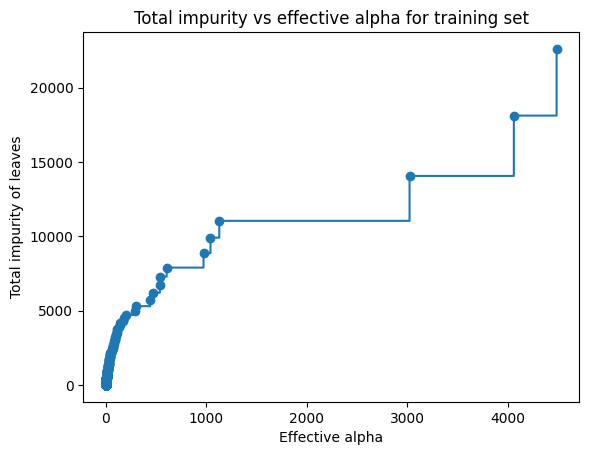

In [ ]:
# Create a new regression tree object
clf_pruning = DecisionTreeRegressor()
# Create a path for all values of alpha, from zero to largest, which leads to the smallest tree.
path = clf_pruning.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
# Plot increase in tree impurity with alpha
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("Effective alpha")
ax.set_ylabel("Total impurity of leaves")
ax.set_title("Total impurity vs effective alpha for training set")
plt.show()

In order to find the optimal value for $\alpha$, which will decrease tree complexity to a point where the model does not over-fit the data while maintaining the highest accuracy, we compute the training and testing scores for all values of $\alpha$.

In [ ]:
# Create a regression tree for each element of the cost complexity path
clfs = []
count = 1
for ccp_alpha in ccp_alphas:
    clf_p = DecisionTreeRegressor(random_state=0, ccp_alpha=ccp_alpha)
    clf_p.fit(X_train, y_train)
    clfs.append(clf_p)
    count+=1
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
  clfs[-1].tree_.node_count, ccp_alphas[-1]))

# Drop the tree with maximum alpha, which is a trivial tree with only one leaf
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

Number of nodes in the last tree is: 3 with ccp_alpha: 25056.93566080757


In [ ]:
# Compute accuracy (MSE or R2) for each value of alpha for both training and testing data
# Select "R²" or "MSE" in the following line

metric = "R²" # "R²" or "MSE"

if metric == "R²":
  train_scores = [clf.score(X_train, y_train) for clf in clfs]
  test_scores = [clf.score(X_test_m, y_test_m) for clf in clfs]
elif metric == "MSE":
  train_scores = [mean_squared_error(y_train, clf.predict(X_train)) for clf in clfs]
  test_scores = [mean_squared_error(y_test_m, clf.predict(X_test_m)) for clf in clfs]
else:
  print("Error: metric not recognized. Please select \"R²\" or \"MSE\".")

# plot the results
fig = go.Figure()
fig.add_trace(go.Scatter(x=ccp_alphas, y=train_scores, mode='lines+markers', name='Train',
                         line=dict(dash='dash', width=2), marker=dict(symbol='circle', size=8)))

fig.add_trace(go.Scatter(x=ccp_alphas, y=test_scores, mode='lines+markers', name='Test',
                         line=dict(dash='dash', width=2), marker=dict(symbol='circle', size=8)))

fig.update_layout(
    title="Accuracy vs alpha for training and testing sets",
    xaxis_title="alpha",
    yaxis_title=metric,
    legend=dict(x=0, y=1, traceorder='normal', orientation='h'),
    margin=dict(l=0, r=0, t=30, b=0),
    height=500,
    width=1000
)

fig.show()


We can magnify the plot to see the point where testing accuracy is highest.

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=ccp_alphas, y=train_scores, mode='lines+markers', name='Train',
                         line=dict(dash='dash', width=2), marker=dict(symbol='circle', size=8)))

fig.add_trace(go.Scatter(x=ccp_alphas, y=test_scores, mode='lines+markers', name='Test',
                         line=dict(dash='dash', width=2), marker=dict(symbol='circle', size=8)))

# Find best alpha that optimizes testing performance
best_alpha = -1
index = -1
if metric == "MSE":
    max_score = 100000
    for i in range(len(test_scores)):
        if test_scores[i] < max_score:
            max_score = test_scores[i]
            best_alpha = ccp_alphas[i]
            index = i
    print("Best MSE: %.2f Watts" % max_score)
    print("Corresponding alpha: %.2f at index %d out of %d indices." % (best_alpha, index, len(test_scores)))
else:
    max_score = -1
    for i in range(len(test_scores)):
        if test_scores[i] > max_score:
            max_score = test_scores[i]
            best_alpha = ccp_alphas[i]
            index = i
    print("Best R²: %.2f %%" % (max_score * 100))
    print("Corresponding alpha: %.2f at index %d out of %d indices." % (best_alpha, index, len(test_scores)))

fig.update_layout(
    title="Accuracy vs alpha for training and testing sets",
    xaxis_title="alpha",
    yaxis_title=metric,
    legend=dict(x=0, y=1, traceorder='normal', orientation='h'),
    margin=dict(l=0, r=0, t=30, b=0),
    height=500,
    width=1000
)

fig.update_xaxes(range=[max(0, best_alpha * 0.5), min(ccp_alphas[-1], best_alpha * 1.5)])
# fig.update_yaxes(range=[0.5, 1.1])  # Uncomment and customize if needed

fig.show()

Best R²: 73.08 %
Corresponding alpha: 102.10 at index 689 out of 713 indices.


Below, a comparison of the prediction of a fully-grown tree ($\alpha = 0$), a tree with the optimal $\alpha$ (the value that yields the best testing accuracy), and the maximum value for alpha, which gives a tree with two splits.

In [ ]:
prediction_alphas = [clf.predict(X_test_m) for clf in [clfs[0], clfs[index], clfs[-1]]]

In [ ]:
print("Maximum depth of unpruned regression tree: ", clfs[0].tree_.max_depth)
print("Number of leaves of unpruned regression tree: ", clfs[0].get_n_leaves())
print("Maximum depth of pruned regression tree: ", clfs[index].tree_.max_depth)
print("Number of leaves of pruned regression tree: ", clfs[index].get_n_leaves())
print("Maximum depth of smallest regression tree: ", clfs[-1].tree_.max_depth)
print("Number of leaves of smallest regression tree: ", clfs[-1].get_n_leaves())

Maximum depth of unpruned regression tree:  19
Number of leaves of unpruned regression tree:  720
Maximum depth of pruned regression tree:  6
Number of leaves of pruned regression tree:  25
Maximum depth of smallest regression tree:  1
Number of leaves of smallest regression tree:  2


Here is a plot of the training predictions for the pruned tree:

In [ ]:
# Plot prediction results
singlePredPlot(y_test_m, prediction_alphas[1], "Decision Tree Regressor, pruned", testxlabels, step)

Below, a comparison of predictions using the fully-grown tree, optimally pruned tree, and the smallest tree with 3 splits, using the testing data.

In [ ]:
singlePredPlot(y_test_m, [prediction_alphas[0], prediction_alphas[1], prediction_alphas[2]], ["Single tree, fully grown", "optimally pruned", "fully pruned"], testxlabels, step)

This is a visual representation of the pruned tree:

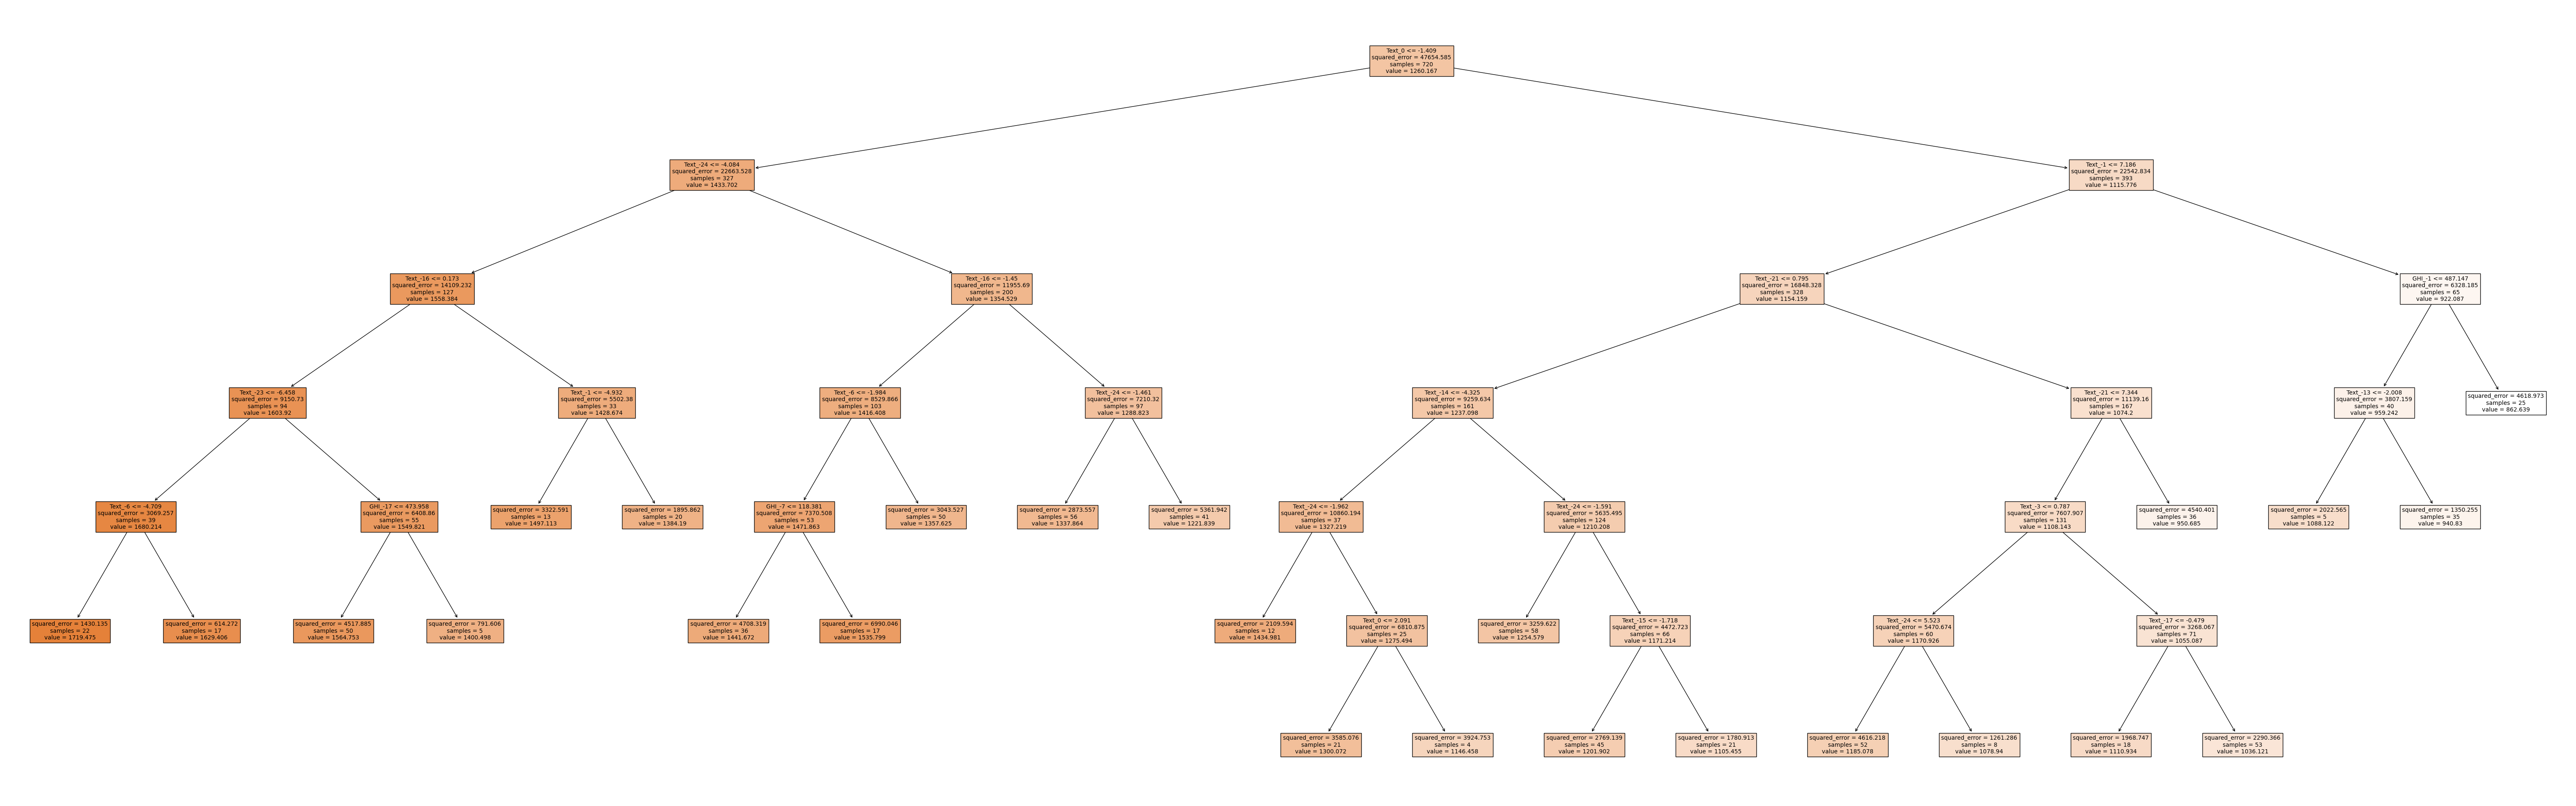

In [ ]:
plt.figure(figsize=(80, 25))
tree.plot_tree(clfs[index], filled=True, fontsize=10, feature_names=X_train.columns)
plt.show()

**Predictor Importance**

Not all predictors provide meaningful information when extracting the regression tree. Here, we assess the importance of each predictor on the model quality, using permutation importance. Read more about it [here](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html?highlight=permutation%20importance). The plot represents the mean accuracy decrease when removing each predictor from a forest of fully-grown trees. This plot informs us about the relative importance of each predictor. For example, we can say that the current external air temperature is the most important predictor when evaluating the system's heating and cooling load.

In [ ]:
# Extract all feature names
feature_names = [str(name) for name in inp.columns]
result = permutation_importance(clfs[0], X_train, y_train, n_repeats=100, random_state=0)
feature_names_pos = []
# Extract mean feature importance, limited to nonzero positive values.
for i in range(len(feature_names)):
  if result.importances_mean[i] > 0:
    feature_names_pos.append(feature_names[i])
forest_importances = pd.Series([importance for importance in result.importances_mean if importance > 0], index=feature_names_pos)

sorted_importances = forest_importances.sort_values()
fig = go.Figure()
fig.add_trace(go.Bar(
    y=sorted_importances.index,
    x=sorted_importances.values,
    orientation='h',
    error_x=dict(type='data', array=[result.importances_std[i] for i in range(len(result.importances_std)) if result.importances_mean[i] > 0]),
    marker=dict(color='rgba(50, 171, 96, 0.6)'),
))

fig.update_layout(
    title="Feature importances using permutation on unpruned tree",
    xaxis_title="Mean accuracy decrease",
    yaxis_title="Features",
    height=600,
    width=1000,
)

fig.show()

If we limit the cost complexity parameter $\alpha$ to the value that we found after pruning, here is the predictor importance plot:

In [ ]:
# Extract all feature names
feature_names = [str(name) for name in inp.columns]
result = permutation_importance(clfs[index], X_train, y_train, n_repeats=100, random_state=0)
feature_names_pos = []
# Extract mean feature importance, limited to nonzero positive values.
for i in range(len(feature_names)):
  if result.importances_mean[i] > 0:
    feature_names_pos.append(feature_names[i])
forest_importances = pd.Series([importance for importance in result.importances_mean if importance > 0], index=feature_names_pos)

fig = go.Figure()
sorted_importances = forest_importances.sort_values()

fig.add_trace(go.Bar(
    y=sorted_importances.index,
    x=sorted_importances.values,
    orientation='h',
    error_x=dict(type='data', array=[result.importances_std[i] for i in range(len(result.importances_std)) if result.importances_mean[i] > 0]),
    marker=dict(color='rgba(50, 171, 96, 0.6)'),
))

fig.update_layout(
    title="Feature importances using permutation on pruned tree",
    xaxis_title="Mean accuracy decrease",
    yaxis_title="Features",
    height=600,
    width=1000,
)

fig.show()

We compute the 1-day predictions, 10 times, at midnight each day for 10 days. We compute the CV(RMSE) on this 10-day prediction.

In [ ]:
final_results = predictWithRetraining(method = clfs[index], name = "Decision tree, pruned", args = retrain_args)

## **Approach 2: Tree Bagging**

The decision trees discussed thus far suffer from high variance. This means that if we split the training data into two parts at random, and fit a decision tree to both halves, the results that we get could be quite different. In contrast, a procedure with low variance will yield similar results if applied repeatedly to distinct data sets; linear regression tends to have low variance if the ratio of $n$ samples to $p$ predictors is moderately large. Bootstrap aggregation, or bagging, is a general-purpose procedure for reducing the variance of a statistical learning method; we introduce it here because it is particularly useful and frequently used in the context of decision trees.

Recall that given a set of $n$ independent observations $Z_1,\ldots,Z_n$, each with variance $\sigma^2$, the variance of the mean $\bar{Z}$ of the observations is given by $\sigma^2/n$. In other words, averaging a set of observations reduces variance. Hence a natural way to reduce the variance and hence increase the prediction accuracy of a statistical learning method is to take many training sets from the population, build a separate prediction model using each training set, and average the resulting predictions. In other words, we could calculate $\hat{f}^1(x), \hat{f}^2(x),\ldots,\hat{f}^B(x)$ using $B$ separate training sets, and average them in order to obtain a single low-variance statistical learning model, given by

\begin{equation}
\hat{f}_{avg}(x) = \frac{1}{B} \sum_{b=1}^B \hat{f}^b(x)
\end{equation}

Of course, this is not practical because we generally do not have access to multiple training sets. Instead, we can bootstrap, by taking repeated samples from the (single) training data set. In this approach we generate $B$ different bootstrapped training data sets. We then train our method on the $b$-th bootstrapped training set in order to get $\hat{f}^{*b}(x)$, and finally average all the predictions, to obtain

\begin{equation}
\hat{f}_{bag}(x) = \frac{1}{B} \sum_{b=1}^B \hat{f}^{*b}(x)
\end{equation}

This is called bagging, short for bootstrap aggregation.

While bagging can improve predictions for many regression methods,
it is particularly useful for decision trees. To apply bagging to regression trees, we simply construct $B$ regression trees using $B$ bootstrapped training sets, and average the resulting predictions. *These trees are grown deep, and are not pruned.* Hence each individual tree has high variance, but low bias. Averaging these $B$ trees reduces the variance. Bagging has been demonstrated to give impressive improvements in accuracy by combining together hundreds or even thousands of trees into a single procedure.

The number of trees $B$ is not a critical parameter with bagging; using a very large value of B will not lead to overfitting. In practice we use a value of B sufficiently large that the error has settled down.

The presented approach uses the Scikit's `BaggingRegressor` method.

**Basic bagging:**

In [ ]:
# Create B = 100 bagged trees
bagged = BaggingRegressor(estimator=DecisionTreeRegressor(), n_estimators=100).fit(X_train, y_train)
prediction_bagging = bagged.predict(X_test_m)

In [ ]:
singlePredPlot(y_test_m, [prediction_bagging, prediction_alphas[1]], ["Bagged trees", "Single pruned tree"], testxlabels, step)

In [ ]:
print("Pruned single tree: \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_alphas[1])*100), mean_squared_error(y_test_m, prediction_unpruned)))
print("Bagging: \t \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_bagging)*100), mean_squared_error(y_test_m, prediction_bagging)))

Pruned single tree: 	 R² = 73.08 % and MSE = 9295.57 Watts
Bagging: 	 	 R² = 79.31 % and MSE = 6365.92 Watts


On the current dataset, tree bagging provides a better estimator than a single pruned tree.

And now predicting 10 days consecutively one after the other.

In [ ]:
bagging_results = predictWithRetraining(method = bagged, name = "Decision tree with bagging", args = retrain_args)

**Random Patches**

Random patches are similar to bagging, except that both the training samples **and** subsets of the predictors are randomly picked for each subtree before combining the subtrees.

Reference: G. Louppe and P. Geurts, “Ensembles on Random Patches”, Machine Learning and Knowledge Discovery in Databases, 346-361, 2012.

In [ ]:
random_patches = BaggingRegressor(estimator=DecisionTreeRegressor(), n_estimators=100, bootstrap_features=True).fit(X_train, y_train)
prediction_random_patches = random_patches.predict(X_test_m)

In [ ]:
singlePredPlot(y_test_m, [prediction_random_patches, prediction_bagging, prediction_alphas[1]], ["Random patches bagging", "Bagged trees", "Single pruned tree"], testxlabels, step)

In [ ]:
print("Pruned single tree: \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_alphas[1])*100), mean_squared_error(y_test_m, prediction_unpruned)))
print("Bagging: \t \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_bagging)*100), mean_squared_error(y_test_m, prediction_bagging)))
print("Random patches: \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_random_patches)*100), mean_squared_error(y_test_m, prediction_random_patches)))

Pruned single tree: 	 R² = 73.08 % and MSE = 9295.57 Watts
Bagging: 	 	 R² = 79.31 % and MSE = 6365.92 Watts
Random patches: 	 R² = 79.99 % and MSE = 6154.84 Watts


The metrics show that random patches, in our case, is superior to bagging for the chosen case.

In [ ]:
patches_results = predictWithRetraining(method = random_patches, name = "Decision tree with random patches", args = retrain_args)

## **Approach 3: Random Forests**

Random forests provide an improvement over bagged trees by way of a small tweak that decorrelates the trees. As in bagging, we build a number of decision trees on bootstrapped training samples. But when building these decision trees, each time a split in a tree is considered, a random sample of $m$ predictors is chosen as split candidates from the full set of $p$ predictors. The split is allowed to use only one of those $m$ predictors. A fresh sample of $m$ predictors is taken at each split, and typically we choose $m \approx \sqrt{p}$, i.e., the number of predictors considered at each split is approximately equal to the square root of the total number of predictors.

In [ ]:
maxFeatures = round(math.sqrt(len(X_train.columns)))
print(maxFeatures)
rndForest = RandomForestRegressor(n_estimators=100, max_features = maxFeatures)
rndForest.fit(X_train, y_train)
prediction_random_forest = rndForest.predict(X_test_m)

7


In [ ]:
singlePredPlot(y_test_m, [prediction_random_forest, prediction_random_patches, prediction_alphas[1]], ["Random forest", "Random patches", "Single pruned tree"], testxlabels, step)

In [ ]:
print("Pruned single tree: \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_alphas[1])*100), mean_squared_error(y_test_m, prediction_unpruned)))
print("Bagging: \t \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_bagging)*100), mean_squared_error(y_test_m, prediction_bagging)))
print("Random patches: \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_random_patches)*100), mean_squared_error(y_test_m, prediction_random_patches)))
print("Random forest: \t \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_random_forest)*100), mean_squared_error(y_test_m, prediction_random_forest)))

Pruned single tree: 	 R² = 73.08 % and MSE = 9295.57 Watts
Bagging: 	 	 R² = 79.31 % and MSE = 6365.92 Watts
Random patches: 	 R² = 79.99 % and MSE = 6154.84 Watts
Random forest: 	 	 R² = 82.53 % and MSE = 5372.60 Watts


In our case, the random forest is significantly better than random patches.

In [ ]:
rnd_forest_results = predictWithRetraining(method = rndForest, name = "Decision tree with random forests", args = retrain_args)

## **Approach 4: Boosting**

We now discuss boosting, yet another approach for improving the predictions resulting from a decision tree. Like bagging, boosting is a general approach that can be applied to many statistical learning methods for regression or classification. Here we restrict our discussion of boosting to the context of decision trees.

Recall that bagging involves creating multiple copies of the original training data set using the bootstrap, fitting a separate decision tree to each copy, and then combining all of the trees in order to create a single predictive model. Notably, each tree is built on a bootstrap data set, independent of the other trees. Boosting works in a similar way, except that the trees are grown sequentially: each tree is grown using information from previously grown trees. Boosting does not involve bootstrap sampling; instead each tree is fit on a modified version of the original data set.

Like bagging, boosting involves combining a large number of decision trees, $\hat{f}^1, \ldots ,\hat{f}^B$. Unlike fitting a single large decision tree to the data, which amounts to fitting the data hard and potentially overfitting, the boosting approach instead learns slowly. Given the current model, we fit a decision tree to the residuals from the model. That is, we fit a tree using the current residuals, rather than the outcome $Y$, as the response. We then add this new decision tree into the fitted function in order to update the residuals. Each of these trees can be rather small, with just a few terminal nodes, determined by the parameter $d$ in the algorithm. By fitting small trees to the residuals, we slowly improve $\hat{f}$ in areas where it does not perform well. The shrinkage parameter $\lambda$ slows the process down even further, allowing more and different shaped trees to attack the residuals. In general, statistical learning approaches that learn slowly tend to perform well. Note that in boosting, unlike in bagging, the construction of each tree depends strongly on the trees that have already been grown.

Boosting has three tuning parameters:
1. The number of trees $B$. Unlike bagging and random forests, boosting can overfit if $B$ is too large, although this overfitting tends to occur slowly if at all.
2. The shrinkage parameter $\lambda$, a small positive number. This controls the rate at which boosting learns. Typical values are 0.01 or 0.001, and the right choice can depend on the problem. Very small $\lambda$ can require using a very large value of $B$ in order to achieve good performance.
3. The number $d$ of splits in each tree, which controls the complexity of the boosted ensemble. Often $d = 1$ works well, in which case each tree is a stump, consisting of a single split. In this case, the boosted ensemble is fitting an additive model, since each term involves only a single variable. More generally $d$ is the interaction depth, and controls the interaction order of the boosted model, since $d$ splits can involve at most $d$ variables.



In [ ]:
boost = AdaBoostRegressor(tree.DecisionTreeRegressor(max_depth = 2), learning_rate = 0.01, n_estimators=5000)
boost.fit(X_train, y_train)
prediction_boost = boost.predict(X_test_m)

In [ ]:
singlePredPlot(y_test_m, [prediction_boost, prediction_random_forest, prediction_alphas[1]], ["AdaBoost", "Random forest", "Single pruned tree"], testxlabels, step)

In [ ]:
print("Pruned single tree: \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_alphas[1])*100), mean_squared_error(y_test_m, prediction_unpruned)))
print("Bagging: \t \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_bagging)*100), mean_squared_error(y_test_m, prediction_bagging)))
print("Random patches: \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_random_patches)*100), mean_squared_error(y_test_m, prediction_random_patches)))
print("Random forest: \t \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_random_forest)*100), mean_squared_error(y_test_m, prediction_random_forest)))
print("Boosting: \t \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_boost)*100), mean_squared_error(y_test_m, prediction_boost)))

Pruned single tree: 	 R² = 73.08 % and MSE = 9295.57 Watts
Bagging: 	 	 R² = 79.31 % and MSE = 6365.92 Watts
Random patches: 	 R² = 79.99 % and MSE = 6154.84 Watts
Random forest: 	 	 R² = 82.53 % and MSE = 5372.60 Watts
Boosting: 	 	 R² = 84.12 % and MSE = 4883.97 Watts


Boosting outperforms bagging, random patches, and a random forest for this case.

In [ ]:
boost_results = predictWithRetraining(method = boost, name = "Decision tree with boosting", args = retrain_args)